# Chapter 5 Socioeconomic Condition 

### This notebook analysis the housing sale price and rental price of the study area in Redhook. Also used time series analysis model to predict the future price accordinly.  This notebook will also bring insights about the rezoning project under the RWCDS condition. 

### written by Yushi (Amber) Chen 

In [1]:
__author = ['Amberchen724']

import pandas as pd 
import geopandas as gpd
from geopandas import GeoDataFrame
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import matplotlib as mpl
import seaborn as sns
#import matplotlib.pylab as pl

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot
import matplotlib.image as mpimg
 
pd.options.mode.chained_assignment = None
%matplotlib inline

### Table of Contents:
* [Background of socioeconomic condition chapter](#1)
* [Housing sale price of study area and time series analysis](#2)
    * [Data Source and Data Cleaning](#3)
    * [Define study area](#4)
    * [EDA](#5)
    * [Time Series Analysis](#6)
* [Housing rental price of study area and time series analysis](#7)
    * [Data Source and Data Cleaning](#8)
    * [EDA](#9)
    * [Time Series Analysis](#10)
* [Findings](#11)
* [RWCDS condition](#12)



<a id='1'></a>
## 1. Background of socioeconomic condition chapter

### The socioeconomic character of an area include its population, housing and economic activities. In the socio-economic chapter, original CEQR tried to measure the direct and indrect (residential and busniess) displacement of the rezoning project. However, the assesment methods result some flawed findings and problems, there are also certain perspectives did not consider into the assesment process. 
### For example: The indirect replacement is poorly assesed in the original CEQR report. The analysis dismisses the potential for inequitable impacts by race and ethnicity. Also, did not consider the indirect displacement that caused by potential property price and rental price increase. In this notebook, I am going to discover the property sales and rental price charateristics in the study area, as well as forcasting the future housing/rental price in the area. 


<a id='2'></a>
## 2. Housing sale price of study area and time series analysis

<a id='3'></a>
## 2.1. Data Source and Data Cleaning

#### Housing Price data are downloaded from NYC Department of Finance: https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

In [2]:
path = "/Users/amber/Documents/DRAW/Time-seriers"

In [3]:
#Combine hoiusing sale data from 2011 to 2019 in one file 

dfs_list = []
# Used separate skiprows values since Excel files were formatted slightly differently
for i in range(2007, 2011):
    temp_df = pd.read_excel('{}/{}_brooklyn.xls'.format(path, i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    
    dfs_list.append(temp_df)
for i in range(2011, 2019):
    temp_df = pd.read_excel('{}/{}_brooklyn.xls'.format(path, i), skiprows=4)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)

    dfs_list.append(temp_df)
pv_df = pd.concat(dfs_list)
pv_df.shape

/Users/amber/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


(285837, 25)

In [4]:
pv_df.to_csv("brooklyn_prices_2007-19.csv")

In [5]:
# Convert 13 years data into csv file
price = pd.read_csv("brooklyn_prices_2007-19.csv")
bk_price=price.drop(['Unnamed: 0'], axis=1)
bk_price.head()

/Users/amber/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,7,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AS OF FINAL ROLL 18/19,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,...,RESIDENTIAL UNITS,SALE DATE,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AS OF FINAL ROLL 18/19,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
0,51 BAY 10TH STREET,,6361,3,NaN,NaN,A5,A5,01 ONE FAMILY HOMES,0.0,...,1.0,2007-08-31,649000,NaN,NaN,1,1,1.0,1930.0,11228.0
1,8611 16TH AVENUE,,6363,3,NaN,NaN,A5,A5,01 ONE FAMILY HOMES,0.0,...,1.0,2007-05-22,520000,NaN,NaN,1,1,1.0,1930.0,11214.0
2,44 BAY 13TH STREET,,6363,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,1.0,2007-11-27,0,NaN,NaN,1,1,1.0,1901.0,11214.0
3,1656 86 STREET,,6364,3,NaN,NaN,S1,S1,01 ONE FAMILY HOMES,1.0,...,1.0,2007-04-18,645000,NaN,NaN,1,1,2.0,1901.0,11214.0
4,79 BAY 20 STREET,,6371,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,1.0,2007-09-12,0,NaN,NaN,1,1,1.0,1930.0,11214.0


<a id='4'></a>
## 2.2. Define study area

In [6]:
# Find data in study area (Use the area file that Ben upload on Github)
pluto =  GeoDataFrame.from_file('pluto.geojson')
pluto.head()

,address,bbl,geometry
0,3 2 PLACE,3003600055,"(POLYGON ((-74.00071 40.680854, -74.000809 40...."
1,3 1 PLACE,3003550049,"(POLYGON ((-74.00028 40.681732, -74.000411 40...."
2,WARREN STREET,3003050121,"(POLYGON ((-73.998088 40.688107, -73.998119 40..."
3,94 DEGRAW STREET,3003290021,"(POLYGON ((-74.003272 40.6859, -74.003399 40.6..."
4,146 DEGRAW STREET,3003300020,"(POLYGON ((-74.001373 40.685371, -74.001498 40..."


In [7]:
# Join Pluto with housing data 
def format_bbl(parcel):
    borough = str(parcel['BOROUGH'])
    block = str(parcel['BLOCK'])
    lot = str(parcel['LOT'])
    return int(borough + block.zfill(5) + lot.zfill(4))

In [8]:
# Create bbls
bk_price['BBL'] = bk_price.apply(format_bbl, axis=1)

In [9]:
study_area_prices = bk_price[bk_price.apply(lambda parcel: parcel['BBL'] in pluto['bbl'].values, axis=1)]
study_area_prices.head(10)

,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AS OF FINAL ROLL 18/19,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,...,SALE DATE,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AS OF FINAL ROLL 18/19,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE,BBL
9276,255 PRESIDENT STREET,,345,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,2007-07-11,0,NaN,NaN,1,1,1.0,1931.0,11231.0,3003450040
9277,90 LUQUER STREET,,376,3,NaN,NaN,S1,S1,01 ONE FAMILY HOMES,1.0,...,2007-06-01,0,NaN,NaN,1,1,2.0,1900.0,11231.0,3003760015
9278,321 SACKETT STREET,,421,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,2007-12-11,0,NaN,NaN,1,1,1.0,1901.0,11231.0,3004210059
9279,321 SACKETT STREET,,421,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,2007-10-18,0,NaN,NaN,1,1,1.0,1901.0,11231.0,3004210059
9280,278 HOYT STREET,,422,3,NaN,NaN,A5,A5,01 ONE FAMILY HOMES,0.0,...,2007-06-01,1795000,NaN,NaN,1,1,1.0,2006.0,11217.0,3004220143
9281,340 SACKETT STREET,,428,3,NaN,NaN,A4,A4,01 ONE FAMILY HOMES,0.0,...,2007-11-09,0,NaN,NaN,1,1,1.0,1901.0,11231.0,3004280022
9282,17 4TH STREET,,464,3,NaN,NaN,A9,A9,01 ONE FAMILY HOMES,0.0,...,2007-01-16,0,NaN,NaN,1,1,1.0,1931.0,11231.0,3004640061
9284,131 SUMMIT STREET,,354,3,NaN,NaN,B9,B9,02 TWO FAMILY HOMES,0.0,...,2007-05-23,1417250,NaN,NaN,1,1,2.0,1899.0,11231.0,3003540044
9285,216 CARROLL STREET,,356,3,NaN,NaN,B9,B9,02 TWO FAMILY HOMES,0.0,...,2007-11-05,1775000,NaN,NaN,1,1,2.0,1899.0,11231.0,3003560019
9286,119 RAPELYEA STREET,4,364,3,NaN,NaN,B1,B1,02 TWO FAMILY HOMES,0.0,...,2007-06-01,1750000,NaN,NaN,1,1,2.0,1930.0,11231.0,3003640034


In [10]:
study_area_prices.to_csv('studyarea_price_0719.csv')

In [11]:
study_area_prices.size

107224

<a id='5'></a>
## 2.3. EDA

In [12]:
data = pd.read_csv('study_data_sales_price0719.csv',index_col=[0], parse_dates=['sale_date'])

In [13]:
time_price = data[['sale_date','sale_price']]
df_time = time_price.set_index(['sale_date'])
df_time.head()

,sale_price
sale_date,
2007-06-01,1795000
2007-05-23,1417250
2007-11-05,1775000
2007-06-01,1750000
2007-08-03,1445300


In [14]:
time_price_means = df_time.resample('M').mean()
time_price_means.head()

,sale_price
sale_date,
2007-01-31,1.389184e+06
2007-02-28,8.950000e+05
2007-03-31,1.327917e+06
2007-04-30,1.487889e+06
2007-05-31,1.000352e+06


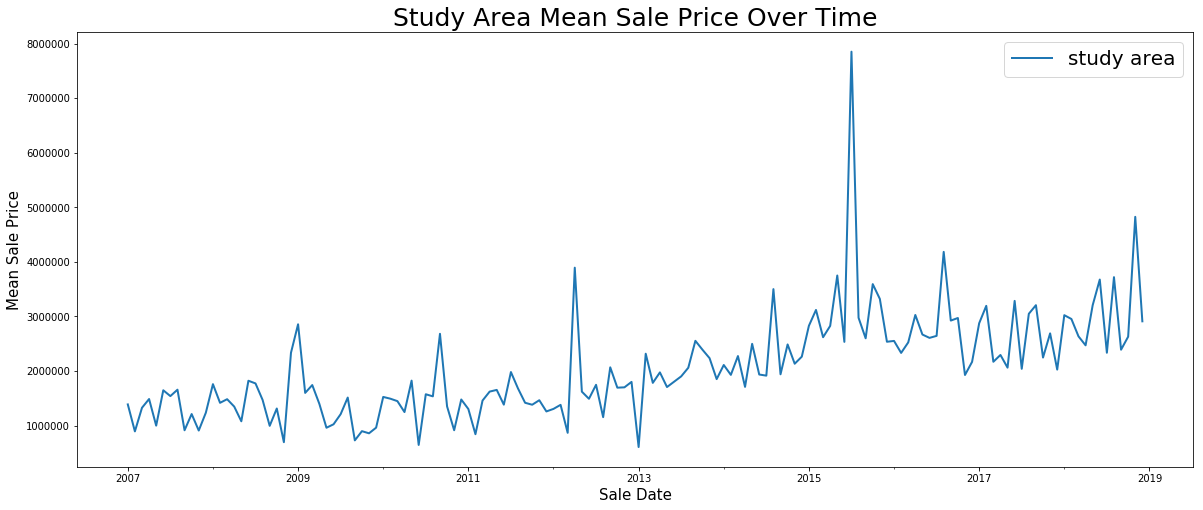

In [15]:
# Visulize the data 

f, ax = plt.subplots(figsize=(20,8))
time_price_means ['sale_price'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

### Explore the seasonality and trend
#### Two methods:
#### Differencing (taking the differece with a particular time lag) 
#### Decomposition (modeling both trend and seasonality and removing them from the model)

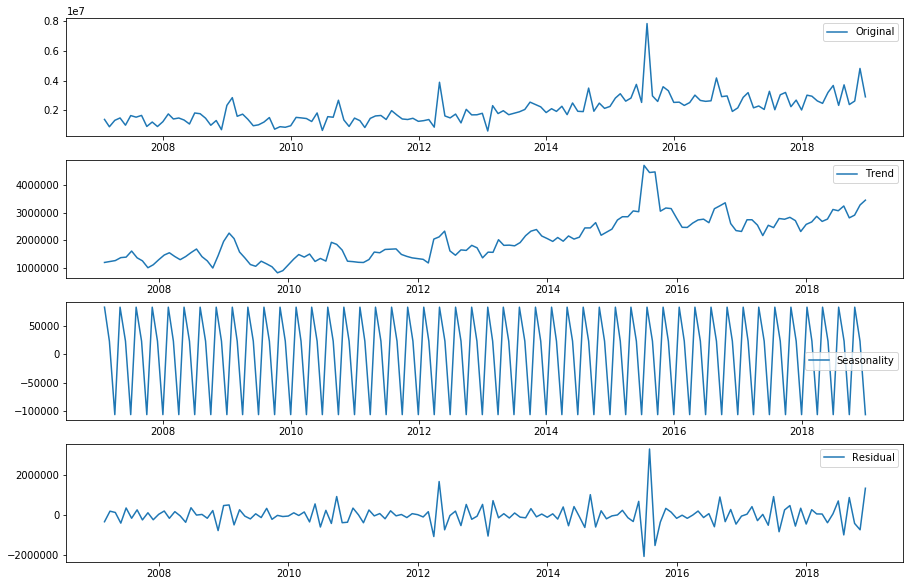

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_price_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_price_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

<a id='6'></a>
## 2.4. time Series Analysis

### Check stationary

#### A stationary time series is one where statistical properties — like the mean and variance — are constant over time.Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. Now we test if our data is staionary: 

In [17]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means.sale_price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_price_means.sale_price.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3125617545283461
p-value: 0.6234058799406687
Critial Values:
   1%, -3.47864788917503
Critial Values:
   5%, -2.882721765644168
Critial Values:
   10%, -2.578065326612056

KPSS Statistic: 0.926708
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/amber/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


#### Based on the ADF test we did before, the p-valur is lower than 5%, then we can reject the nun hypothesis and accept that stationarity exists in the data.
### Make data from non-staionary to stationary 

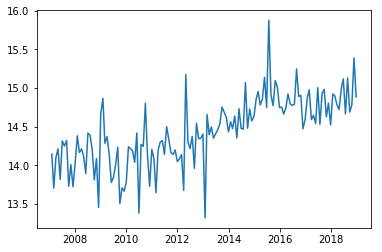

In [18]:
price_log = np.log(time_price_means)
plt.plot(price_log)

In [19]:
time_price_means['diff_price'] = time_price_means.sale_price -time_price_means.sale_price.shift(6)
time_price_means_diff = time_price_means.dropna()
time_price_means_diff.head()

,sale_price,diff_price
sale_date,,
2007-07-31,1.541417e+06,152232.512821
2007-08-31,1.658950e+06,763950.000000
2007-09-30,9.155400e+05,-412376.666667
2007-10-31,1.212889e+06,-275000.000000
2007-11-30,9.105547e+05,-89797.761905


In [20]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means_diff.diff_price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.7734021496746433
p-value: 0.00319147466284833
Critial Values:
   1%, -3.4833462346078936
Critial Values:
   5%, -2.8847655969877666
Critial Values:
   10%, -2.5791564575459813


In [21]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_price_means.sale_price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [23]:
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_price_means.sale_price,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1984      0.193     -1.027      0.304      -0.577       0.180
ma.L1         -0.7003      0.116     -6.031      0.000      -0.928      -0.473
ma.S.L12      -0.8881      0.113     -7.862      0.000      -1.110      -0.667
sigma2      1.055e+12    1.2e-13   8.79e+24      0.000    1.05e+12    1.05e+12


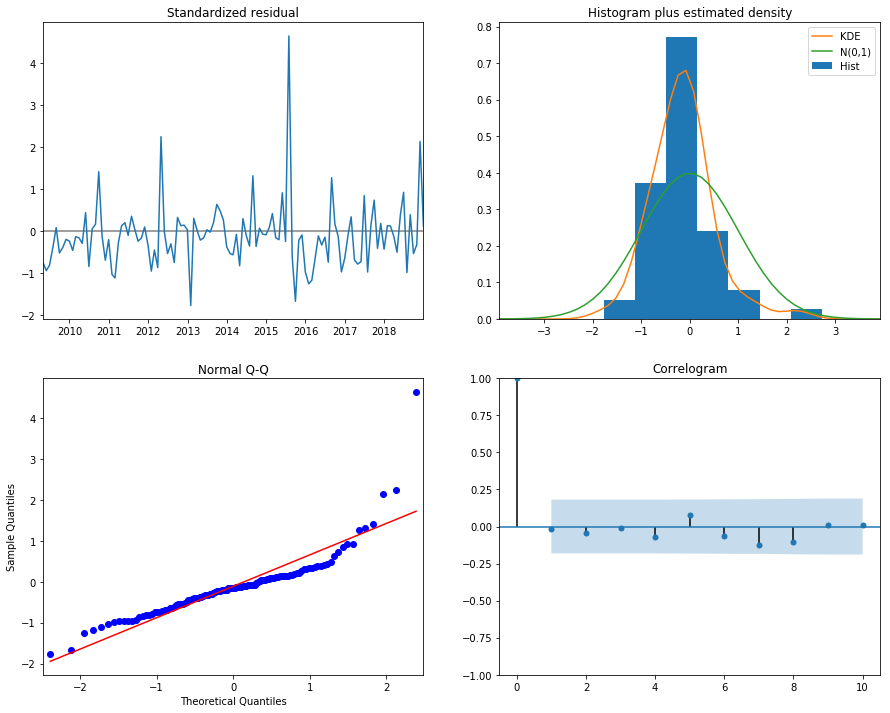

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Validating Forecasts

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

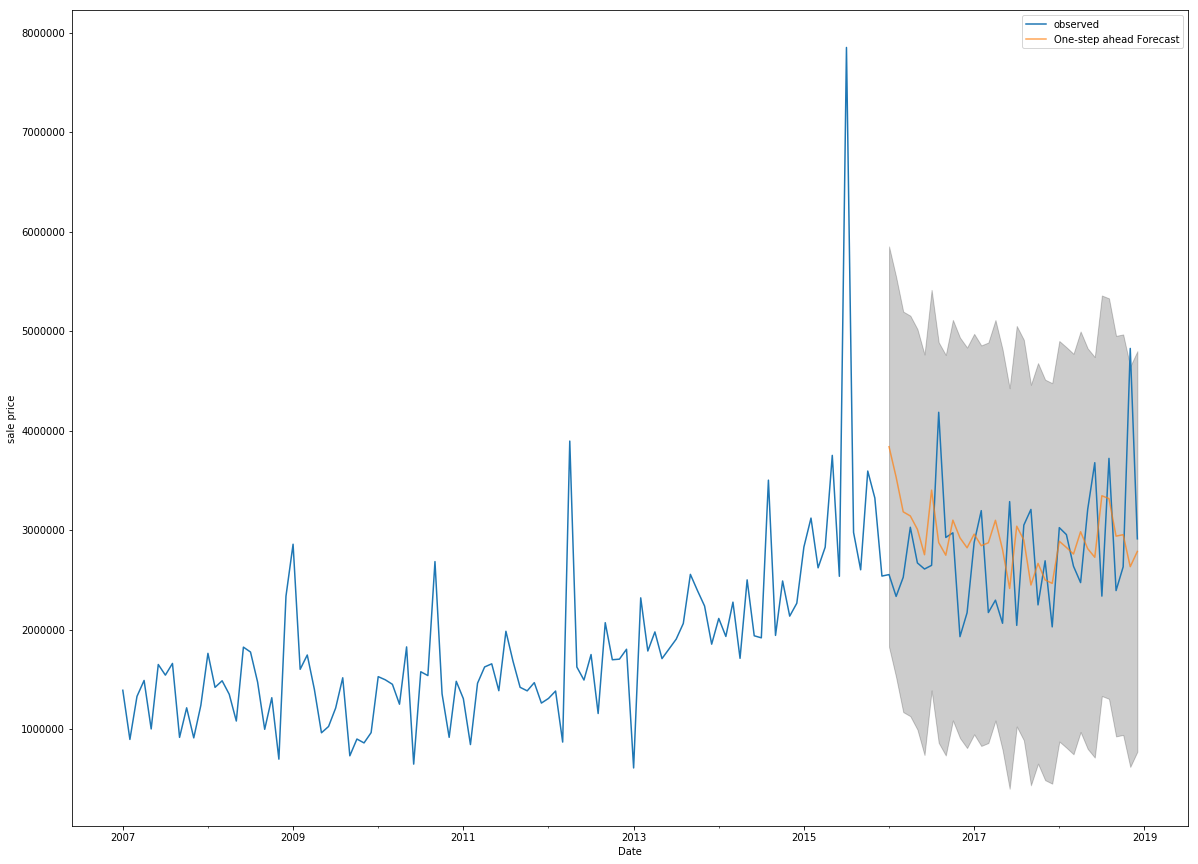

In [26]:
ax =time_price_means.sale_price['2007':].plot(label='observed',figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('sale price')
plt.legend()

plt.show()

In [27]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

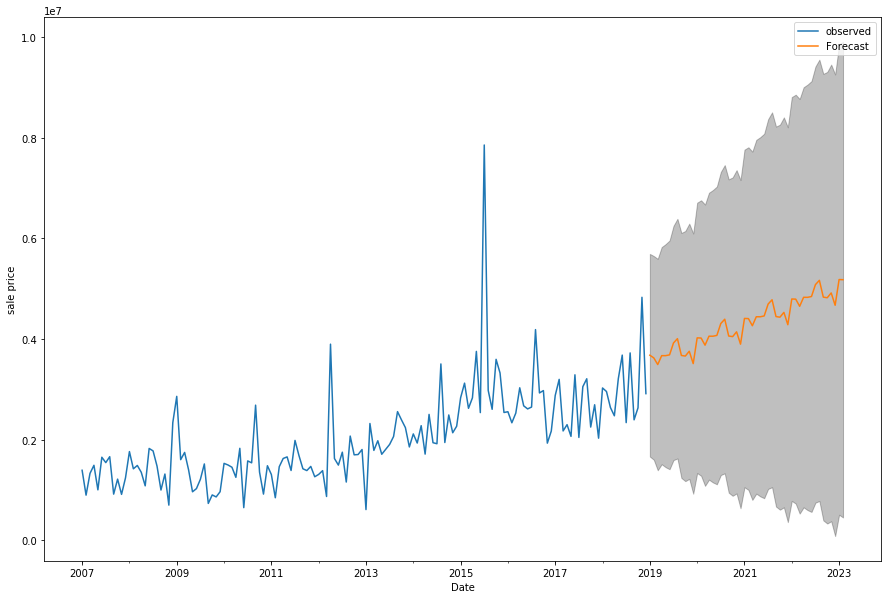

In [28]:
ax =  time_price_means.sale_price.plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('sale price')

plt.legend()
plt.show()


# Based on the characteristics of the study area, 80% of the residence are renter, thus performing prediction on rental price is more meaningful 

<a id='7'></a>
## 3. Housing rental price of study area and time series analysis

<a id='8'></a>
## 3.1 Data Source and Data Cleaning

#### Data downloaded from streeteas:https://streeteasy.com/blog/data-dashboard/

### Studio

In [29]:
studio = pd.read_csv('medianAskingRent_Studio.csv')
studio.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,All Downtown,Manhattan,submarket,2350.0,2300.0,2200.0,2250.0,2300.0,2300.0,2290.0,...,2795.0,2800.0,2850.0,2795.0,2804.0,2815.0,2855.0,2900.0,2900.0,2900.0
1,All Midtown,Manhattan,submarket,2000.0,1995.0,1995.0,2000.0,2000.0,2000.0,2050.0,...,2595.0,2595.0,2575.0,2565.0,2595.0,2670.0,2650.0,2695.0,2650.0,2675.0
2,All Upper East Side,Manhattan,submarket,1750.0,1750.0,1750.0,1780.0,1800.0,1750.0,1750.0,...,2050.0,2099.0,2100.0,2128.0,2108.0,2150.0,2100.0,2150.0,2150.0,2163.0
3,All Upper Manhattan,Manhattan,submarket,1175.0,1150.0,1150.0,1150.0,1150.0,1195.0,1250.0,...,1750.0,1795.0,1795.0,1750.0,1700.0,1700.0,1700.0,1750.0,1700.0,1750.0
4,All Upper West Side,Manhattan,submarket,1800.0,1800.0,1795.0,1800.0,1895.0,1895.0,1800.0,...,2300.0,2295.0,2200.0,2200.0,2255.0,2300.0,2300.0,2350.0,2400.0,2395.0


#### Data contains rental price in many area, drop other area and keep the study area. There are many nan in RedHook data, so we also drop it. 

In [30]:
studio_study= studio.loc[studio['areaName'] == 'Red Hook']
studio_study2 = studio_study.dropna(axis=1, how="all")

In [31]:
studio_study3=studio_study2.drop(['Borough','areaType'], axis=1)
studio_study4 = studio_study3.set_index(['areaName'])

In [32]:
df_studio= studio_study4.T

In [33]:
df = df_studio.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_oneb'})

In [34]:
df_studio= studio_study4.T

In [35]:
df = df_studio.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_studio'})
df.head()

areaName,medianAskingRent_studio
2014-10,2500.0
2017-06,2300.0
2017-07,2400.0
2017-08,2350.0
2017-10,2775.0


## One-Bedroom

In [36]:
oneb = pd.read_csv('medianAskingRent_Onebd.csv')
oneb.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,All Downtown,Manhattan,submarket,2995.0,2950.0,2900.0,2975.0,2995.0,3000.0,3000.0,...,3500.0,3550.0,3599.0,3600.0,3700.0,3695.0,3700.0,3750.0,3700.0,3800.0
1,All Midtown,Manhattan,submarket,2800.0,2800.0,2850.0,2895.0,2900.0,2990.0,3000.0,...,3495.0,3500.0,3500.0,3500.0,3495.0,3509.0,3500.0,3550.0,3595.0,3620.0
2,All Upper East Side,Manhattan,submarket,2350.0,2300.0,2350.0,2470.0,2500.0,2500.0,2500.0,...,2778.0,2775.0,2780.0,2850.0,2900.0,2950.0,2950.0,2995.0,2950.0,2850.0
3,All Upper Manhattan,Manhattan,submarket,1500.0,1516.0,1545.0,1516.0,1550.0,1575.0,1550.0,...,1995.0,1959.0,1950.0,1950.0,1950.0,1950.0,1995.0,1995.0,1995.0,1995.0
4,All Upper West Side,Manhattan,submarket,2600.0,2550.0,2495.0,2500.0,2500.0,2600.0,2600.0,...,3050.0,3050.0,3100.0,3162.0,3099.0,3167.0,3240.0,3200.0,3225.0,3398.0


In [37]:
oneb_study= oneb.loc[oneb['areaName'] == 'Red Hook']
oneb_study2 = oneb_study.dropna(axis=1, how="all")

In [38]:
oneb_study3=oneb_study2.drop(['Borough','areaType'], axis=1)
oneb_study4 = oneb_study3.set_index(['areaName'])

In [39]:
df_oneb= oneb_study4.T

In [40]:
df1 =df_oneb.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_oneb'})
df1.head()

areaName,medianAskingRent_oneb
2010-10,1450.0
2010-11,1488.0
2012-03,2000.0
2012-05,1950.0
2012-06,2000.0


## Two Bedroom

In [41]:
twob = pd.read_csv('medianAskingRent_Twobd.csv')
twob.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,All Downtown,Manhattan,submarket,4400.0,4450.0,4400.0,4400.0,4400.0,4295.0,4295.0,...,4200.0,4200.0,4467.0,4569.0,4659.0,4750.0,4995.0,4781.0,4471.0,4334.0
1,All Midtown,Manhattan,submarket,4700.0,4500.0,4500.0,4495.0,4500.0,4500.0,4495.0,...,4600.0,4708.0,4685.0,4723.0,4798.0,4800.0,4871.0,4901.0,4800.0,4874.0
2,All Upper East Side,Manhattan,submarket,3500.0,3650.0,3800.0,3950.0,3965.0,3900.0,3800.0,...,3495.0,3495.0,3600.0,3500.0,3650.0,3870.0,3950.0,3950.0,3800.0,3685.0
3,All Upper Manhattan,Manhattan,submarket,2000.0,1985.0,1950.0,1950.0,1975.0,1975.0,2000.0,...,2500.0,2495.0,2475.0,2400.0,2395.0,2400.0,2450.0,2496.0,2500.0,2500.0
4,All Upper West Side,Manhattan,submarket,4200.0,4100.0,4100.0,4498.0,4500.0,4500.0,3995.0,...,4400.0,4500.0,4577.0,4725.0,4579.0,4500.0,4656.0,4600.0,4336.0,4250.0


In [42]:
twob_study= twob.loc[oneb['areaName'] == 'Red Hook']
twob_study2= twob_study.dropna(axis=1, how="all")

In [43]:
twob_study3=twob_study2.drop(['Borough','areaType'], axis=1)
twob_study4 = twob_study3.set_index(['areaName'])

In [44]:
df_twob= twob_study4.T

In [45]:
df2 =df_twob.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_twob'})

In [46]:
df2.head()

areaName,medianAskingRent_twob
2013-02,2100.0
2014-05,3000.0
2014-06,3000.0
2014-07,3000.0
2014-08,3000.0


## More than 3 Bedrooms

In [47]:
three = pd.read_csv('medianAskingRent_ThreePlusBd.csv')
three.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,All Downtown,Manhattan,submarket,6700.0,6500.0,6500.0,6798.0,6798.0,6000.0,6000.0,...,5898.0,6000.0,6000.0,6141.0,6667.0,6667.0,7326.0,6888.0,6900.0,6400.0
1,All Midtown,Manhattan,submarket,7948.0,8000.0,6900.0,5995.0,6500.0,7125.0,7500.0,...,5760.0,5798.0,5955.0,5895.0,5995.0,6038.0,6200.0,6414.0,5719.0,6100.0
2,All Upper East Side,Manhattan,submarket,8950.0,9000.0,9900.0,8400.0,8100.0,7725.0,7500.0,...,6650.0,6900.0,7973.0,7995.0,8395.0,8995.0,9595.0,8995.0,9500.0,8475.0
3,All Upper Manhattan,Manhattan,submarket,2700.0,2673.0,2600.0,2795.0,2800.0,2600.0,2600.0,...,3295.0,3300.0,3208.0,3036.0,3000.0,2999.0,3000.0,3000.0,3025.0,3195.0
4,All Upper West Side,Manhattan,submarket,7000.0,7000.0,7000.0,7950.0,8995.0,8500.0,7225.0,...,6000.0,6800.0,7000.0,7000.0,7950.0,7997.0,8100.0,7661.0,6995.0,6750.0


In [48]:
three_study= three.loc[oneb['areaName'] == 'Red Hook']
three_study2 = three_study.dropna(axis=1, how="all")

In [49]:
three_study3=three_study2.drop(['Borough','areaType'], axis=1)
three_study4 = three_study3.set_index(['areaName'])

In [50]:
df_threeb= three_study4.T

In [51]:
df3 =df_threeb.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_threeb'})

In [52]:
df3.head()

areaName,medianAskingRent_threeb
2013-01,3000.0
2013-05,2600.0
2015-10,3550.0
2015-11,3393.0
2015-12,3300.0


## Combine four datasets 

In [53]:
df_new = pd.concat([df,df1, df2,df3], axis=1)

In [54]:
df_new.head()

areaName,medianAskingRent_studio,medianAskingRent_oneb,medianAskingRent_twob,medianAskingRent_threeb
2010-10,NaN,1450.0,NaN,NaN
2010-11,NaN,1488.0,NaN,NaN
2012-03,NaN,2000.0,NaN,NaN
2012-05,NaN,1950.0,NaN,NaN
2012-06,NaN,2000.0,NaN,NaN


In [55]:
df_index_all = df_new.reset_index()

<a id='9'></a>
## 3.2 EDA

In [56]:
# change the string to datetime 
df_index_all['index'] =  pd.to_datetime(df_index_all['index'])

In [57]:
df_all_time = df_index_all.set_index(['index'])

In [58]:
# aggragate data based on monthly value
time_means_all = df_all_time.resample('M').mean()
time_means_all.head()

areaName,medianAskingRent_studio,medianAskingRent_oneb,medianAskingRent_twob,medianAskingRent_threeb
index,,,,
2010-10-31,NaN,1450.0,NaN,NaN
2010-11-30,NaN,1488.0,NaN,NaN
2010-12-31,NaN,NaN,NaN,NaN
2011-01-31,NaN,NaN,NaN,NaN
2011-02-28,NaN,NaN,NaN,NaN


In [59]:
# Using "ffill" method to fill in the missing values. 
df_all=time_means_all.fillna(method='ffill')
df_all.head()

areaName,medianAskingRent_studio,medianAskingRent_oneb,medianAskingRent_twob,medianAskingRent_threeb
index,,,,
2010-10-31,NaN,1450.0,NaN,NaN
2010-11-30,NaN,1488.0,NaN,NaN
2010-12-31,NaN,1488.0,NaN,NaN
2011-01-31,NaN,1488.0,NaN,NaN
2011-02-28,NaN,1488.0,NaN,NaN


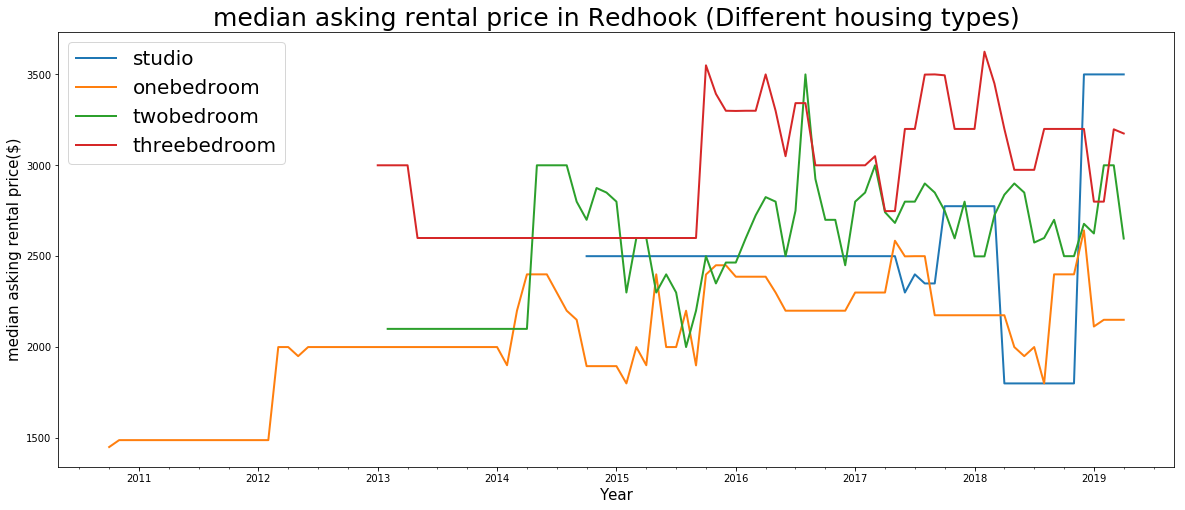

In [60]:
# Plot the rental price in different rental categories 
f, ax = plt.subplots(figsize=(20,8))
df_all['medianAskingRent_studio'].plot(alpha=1,linewidth=2,ax=ax,label='studio')
df_all['medianAskingRent_oneb'].plot(alpha=1,linewidth=2,ax=ax,label='onebedroom')
df_all['medianAskingRent_twob'].plot(alpha=1,linewidth=2,ax=ax,label='twobedroom')
df_all['medianAskingRent_threeb'].plot(alpha=1,linewidth=2,ax=ax,label='threebedroom')

plt.title("median asking rental price in Redhook (Different housing types)", fontsize=25)
plt.xlabel("Year", fontsize=15)
plt.ylabel("median asking rental price($)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

### Based on the graph showed above, the rental price of studio changed the most, even the rental price for studio has a lot of missing data. The price of three bedroom is decreasing in 2019, which the two bedroom rental price is increasing in 2019. 

## Median asking price for all types of rental unit together

In [61]:
all_rent = pd.read_csv('medianAskingRent_All.csv')
all_rent.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,All Downtown,Manhattan,submarket,3200.0,3200.0,3025.0,3100.0,3100.0,3200.0,3195.0,...,3800.0,3800.0,3831.0,3800.0,3876.0,3800.0,3800.0,3895.0,3800.0,3965.0
1,All Midtown,Manhattan,submarket,2895.0,2800.0,2800.0,2850.0,2900.0,2950.0,3000.0,...,3503.0,3500.0,3518.0,3550.0,3533.0,3575.0,3500.0,3559.0,3554.0,3600.0
2,All Upper East Side,Manhattan,submarket,2469.0,2450.0,2400.0,2500.0,2550.0,2550.0,2595.0,...,2910.0,2900.0,2895.0,2995.0,2995.0,3000.0,3000.0,3000.0,2995.0,2995.0
3,All Upper Manhattan,Manhattan,submarket,1825.0,1800.0,1795.0,1800.0,1823.0,1850.0,1875.0,...,2430.0,2400.0,2350.0,2350.0,2300.0,2300.0,2300.0,2337.0,2383.0,2400.0
4,All Upper West Side,Manhattan,submarket,2895.0,2800.0,2750.0,2800.0,2798.0,2795.0,2800.0,...,3345.0,3324.0,3400.0,3400.0,3395.0,3400.0,3400.0,3375.0,3400.0,3500.0


In [62]:
all_study= all_rent.loc[all_rent['areaName'] == 'Red Hook']
all_study2 = all_study.dropna(axis=1, how="all")

In [63]:
all_study3=all_study2.drop(['Borough','areaType'], axis=1)
all_study4 = all_study3.set_index(['areaName'])
all_study4

,2010-01,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-06,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
areaName,,,,,,,,,,,,,,,,,,,,,
Red Hook,2000.0,2200.0,2150.0,1800.0,1850.0,1750.0,1700.0,1650.0,1750.0,1925.0,...,2550.0,2600.0,2625.0,2500.0,2700.0,2767.0,2613.0,2750.0,2800.0,2700.0


In [64]:
#drop the year has too much missing value
all_study5 = all_study4.drop(['2010-01', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01','2011-02', '2011-03', '2011-04', '2011-06', '2011-07', '2011-08',  '2011-10','2011-11', '2011-12'], axis=1)
df_all= all_study5.T

In [65]:
df_all_new =df_all.rename(columns={'areaName': 'year', 'Red Hook': 'medianAskingRent_all'})

In [66]:
df_index = df_all_new.reset_index()
df_index.head()

areaName,index,medianAskingRent_all
0,2012-01,1950.0
1,2012-02,2000.0
2,2012-03,2000.0
3,2012-04,2300.0
4,2012-05,2250.0


In [67]:
df_index['index'] =  pd.to_datetime(df_index['index'])

In [68]:
df_index_time = df_index.set_index(['index'])

In [69]:
time_means = df_index_time.resample('M').mean()

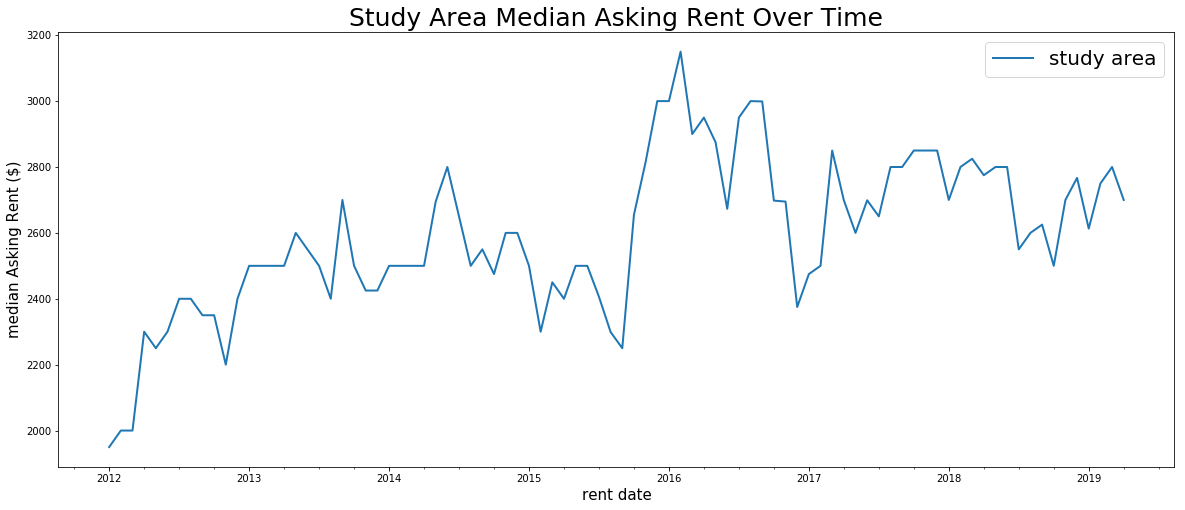

In [70]:
# Visulize the data 
f, ax = plt.subplots(figsize=(20,8))
time_means['medianAskingRent_all'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Median Asking Rent Over Time", fontsize=25)
plt.xlabel("rent date", fontsize=15)
plt.ylabel("median Asking Rent ($)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

### The total rental price was in a peak in 2016, decreased after 2016 until reached the lowest point at 2017. 

<a id='10'></a>
## 3.3 Time series analysis

#### Check the trend and seaonality of the data 

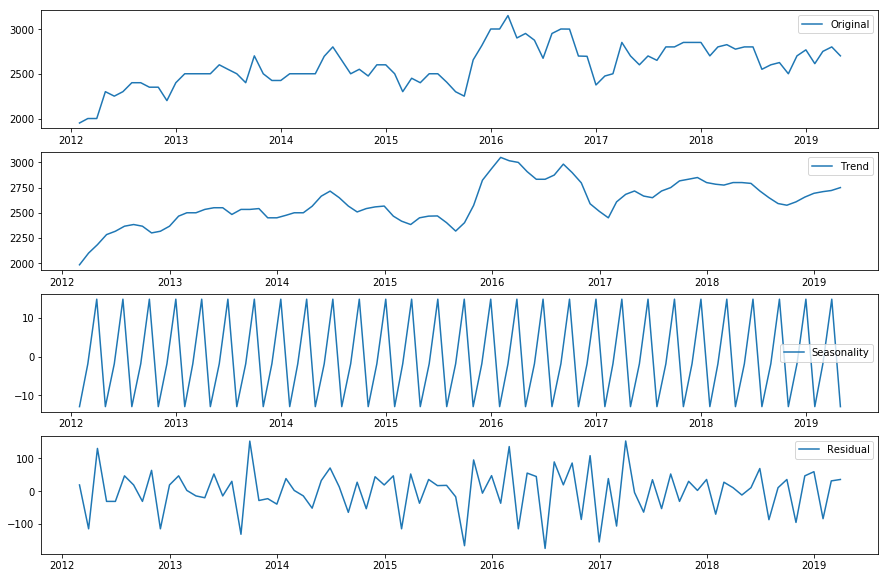

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

#### Check stationality of the data 

In [72]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_means.medianAskingRent_all.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_means.medianAskingRent_all.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.614945058756197
p-value: 0.005481654837441642
Critial Values:
   1%, -3.5078527246648834
Critial Values:
   5%, -2.895382030636155
Critial Values:
   10%, -2.584823877658872

KPSS Statistic: 0.602946
p-value: 0.022369
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


## Use ARIMA model for time series prediction 

In [73]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [74]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_means.medianAskingRent_all,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1617.735742436614
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1314.8828550457613
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1071.624333480641
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:884.4900146413135
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1088.301151870335
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1054.7029821924014
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:897.4535075342596
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:884.3752254788768
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1489.4810043516711
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1214.0630118516542
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1025.7988116797062
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:841.5171152277935
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1057.5055253915755
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:995.3634995403511
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:867.8235082650799
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:840.5011678581999
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1092.6940907024064
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:940.6593111951071
ARI

### Choose ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:802.4247636972309, as the best model

In [75]:
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_means.medianAskingRent_all,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:               medianAskingRent_all   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -396.212
Date:                            Thu, 06 Jun 2019   AIC                            802.425
Time:                                    23:23:54   BIC                            812.979
Sample:                                01-31-2012   HQIC                           806.561
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6961      0.138      5.045      0.000       0.426       0.967
ma.L1         -1.0245      0.295   

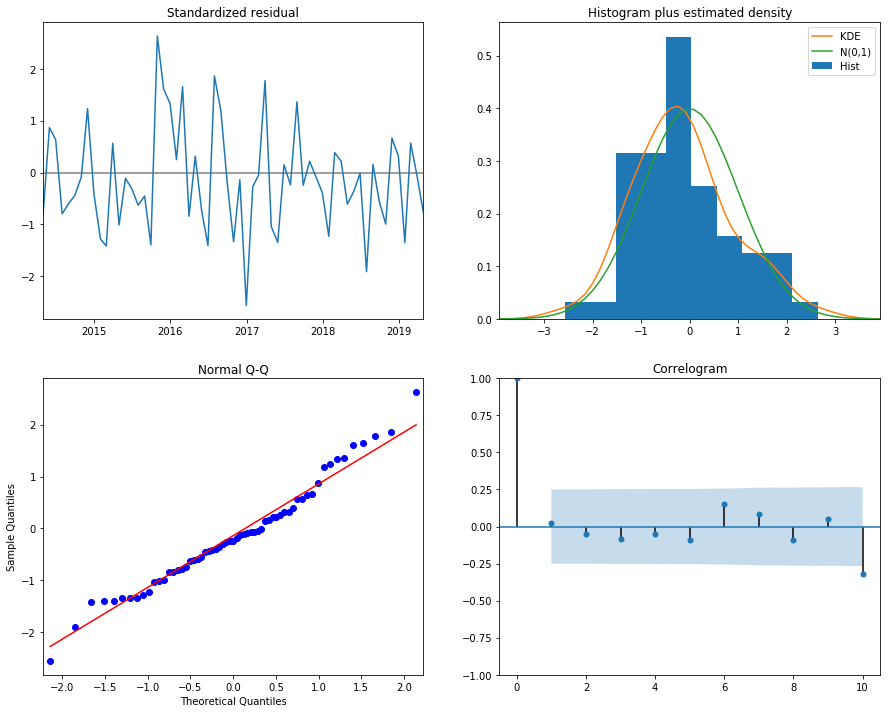

In [76]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#### Validating 

In [77]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

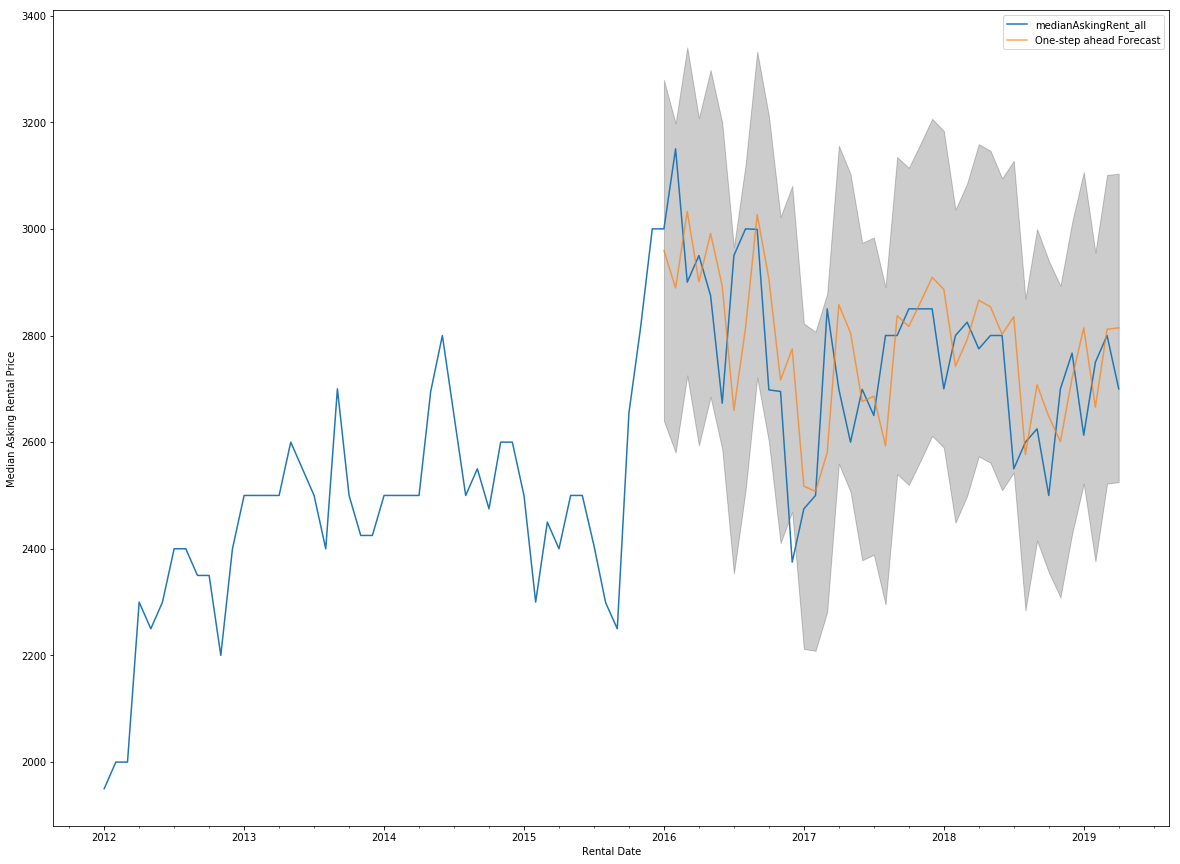

In [78]:
ax =time_means['2007':].plot(label='observed',figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Rental Date')
ax.set_ylabel('Median Asking Rental Price')
plt.legend()

plt.show()

In [79]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

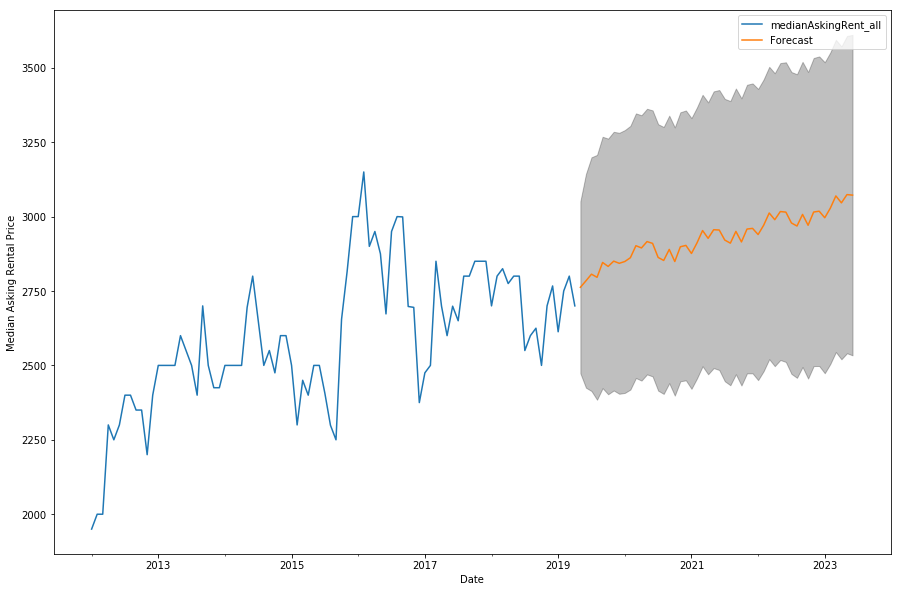

In [80]:
ax = time_means.plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Asking Rental Price')

plt.legend()
plt.show()

`<a id='11'></a>
## 4. Findings

## From previous analysis on the price of property sales and rental unit: 
### 1. The proerty sale price will be increase based on the time series forcasting, and the trend of incresing will continue for next five years. There are definalty seasonality exsit in the housing market of the study area, which the mean price of the hoiusing market in Summer is higher than Winter. However, based on the socio-economic characteristic analysis, the unemployment rate of the study area is higher than brooklyn, which the increasing sale price of housing may increase the burden of the housing buyer and lead to indirect displacement. 
### 2. Based on the socio-economic characteristic analysis, 80% of the residence in the study area are renter instead of home owner, which analyze rental price of the preperty in the study area is more meaningful
### 3. started from 2018, the median asking rental price of threebedroom housing is generaly decreasing, and price for onebedroom and two bedroom increases with fluctuation. In january and feburay of 2019, the twobedroom rental price is higher than the price of threebedroom. 
### 4. According to the time series analysis of rental price,  the trend of rental price is also increasing but with fluctuation. 

`<a id='12'></a>
## 5. RWCDS condition

### two stories (approximately 1.8 FAR 144,000 zsf or 148,320 gsf) of industrial uses, with a remaining permissible 2.8 FAR (224,000 zsf or 246,400 gsf) being comprised of approximately 246 dwelling units, of which between 20 and 30 percent would be permanently affordable in accordance with the MIH program;  Metrics for jobs per sf: warehouses: 1 per 3,000 sf; manufacturing / makers’ space: 1 per 600 sf; offices: 1 per 200 sf Lots 1, 23 and 24 will be included in the RWCDS as the sole development site;  Construction activities (including demolition) would take up to 24 months. The preparation of an Environmental Impact Statement (EIS) will not be required. 

### It also should include that, in the 70%-80% of the rental unit, the precentage of twobedroom and single bedroom property should be increased.